In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat', \
#                     format='basic', delimiter='\s')
parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


# r13
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&
                (lmc['M_H_ERR']>-100.0)&(lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

# Diane Feuillet
pdfout = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/LMC_DR16_all_PDF.fits.gz', 1)
_, lmc_ind, pdfout_ind = np.intersect1d(lmc['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [4]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=lmc['RA']*u.degree, dec=lmc['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [102]:
from sklearn.model_selection import train_test_split
import itertools as it

### Split Training and Testing Data
# X = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Z']/0.02),parsec['logg']]).T
# y = parsec['logAge']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# # Training Data
# lgte_train = X_train[:,0]
# kmag_train = X_train[:,1]
# feh_train = X_train[:,2]
# logg_train = X_train[:,3] 
# age_train = y_train

# # Test Data
# lgte_test = X_test[:,0]
# kmag_test = X_test[:,1]
# feh_test = X_test[:,2]
# logg_test = X_test[:,3]
# age_test = y_test

### Model Variables ###

# linear terms
lgte_train = parsec['logTe'] #X_train[:,0]
kmag_train = parsec['Ksmag'] #X_train[:,1]
feh_train = np.log10(parsec['Z']/0.02) #X_train[:,2]
logg_train = parsec['logg'] #X_train[:,3]

# linear int
lgtekmag_train = np.multiply(lgte_train,kmag_train)
lgtefeh_train = np.multiply(lgte_train,feh_train)
lgtelogg_train = np.multiply(lgte_train,logg_train)

kmagfeh_train = np.multiply(kmag_train,feh_train)
kmaglogg_train = np.multiply(kmag_train,logg_train)

fehlogg_train = np.multiply(feh_train,logg_train)

# squares
lgtesq_train = lgte_train**2
kmagsq_train = kmag_train**2
fehsq_train = feh_train**2
loggsq_train = logg_train**2

# cubes
lgtecu_train = lgte_train**3
kmagcu_train = kmag_train**3
fehcu_train = feh_train**3
loggcu_train = logg_train**3


#find all possible models
models = []
models_str = []

all_var_str = ['lgte','kmag','feh','logg','lgtekmag','lgtefeh','lgtelogg','kmagfeh','kmaglogg','fehlogg',
               'lgtesq','kmagsq','fehsq','loggsq','lgtecu','kmagcu','fehcu','loggcu']
all_var = [lgte_train,kmag_train,feh_train,logg_train,lgtekmag_train,lgtefeh_train,lgtelogg_train,kmagfeh_train,
           kmaglogg_train,fehlogg_train,lgtesq_train,kmagsq_train,fehsq_train,loggsq_train,lgtecu_train,
           kmagcu_train,fehcu_train,loggcu_train]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    residual = model.predict(pmodl) - parsec['logAge']
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)

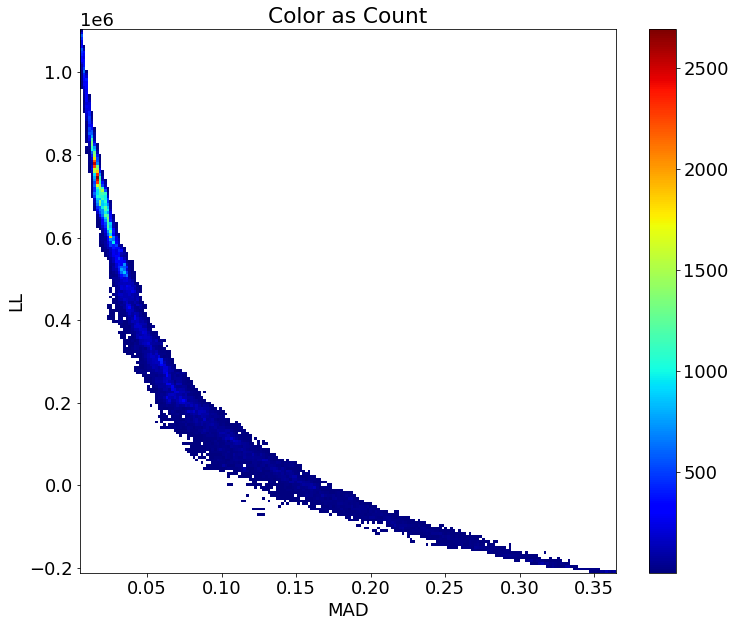

min mad:  0.004819022634267256
max ll:  1104519.0534554191


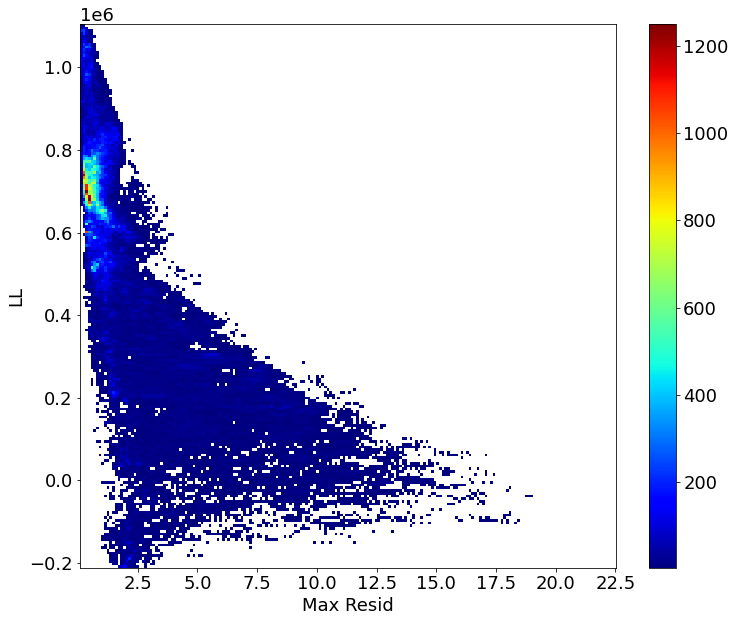

min max resid:  0.0792578822902339
max ll:  1104519.0534554191


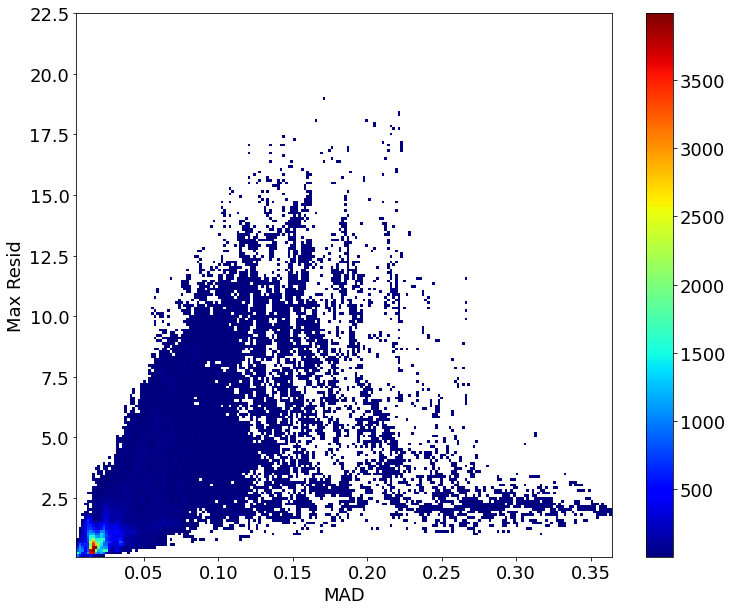

min mad:  0.004819022634267256
min max resid:  0.0792578822902339


In [103]:
from scipy.stats import binned_statistic_2d

max_resid = np.asarray(max_resid)
mads = np.asarray(mads)
ll = np.asarray(ll)

madsll = binned_statistic_2d(mads,ll,mads,'count',bins=200,expand_binnumbers=True)
plt.figure(figsize=[12,10])
madsll.statistic[madsll.statistic<2.] = np.nan
plt.imshow(madsll.statistic.T, origin='lower',
           extent=[madsll.x_edge[0],madsll.x_edge[-1],madsll.y_edge[0],madsll.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')
plt.colorbar()
plt.xlabel('MAD')
plt.ylabel('LL')
plt.title('Color as Count')
plt.show()
print('min mad: ',min(mads))
print('max ll: ',max(ll))

maxresidll = binned_statistic_2d(max_resid,ll,mads,'count',bins=200,expand_binnumbers=True)
plt.figure(figsize=[12,10])
maxresidll.statistic[maxresidll.statistic<2.] = np.nan
plt.imshow(maxresidll.statistic.T, origin='lower',
           extent=[maxresidll.x_edge[0],maxresidll.x_edge[-1],maxresidll.y_edge[0],maxresidll.y_edge[-1]],
           aspect='auto',interpolation='nearest', cmap='jet')
plt.colorbar()
plt.xlabel('Max Resid')
plt.ylabel('LL')
plt.show()
print('min max resid: ',min(max_resid))
print('max ll: ',max(ll))

madsmaxresid = binned_statistic_2d(mads,max_resid,mads,'count',bins=200,expand_binnumbers=True)
plt.figure(figsize=[12,10])
madsmaxresid.statistic[madsmaxresid.statistic<2.] = np.nan
plt.imshow(madsmaxresid.statistic.T, origin='lower',
           extent=[madsmaxresid.x_edge[0],madsmaxresid.x_edge[-1],madsmaxresid.y_edge[0],madsmaxresid.y_edge[-1]],
           aspect='auto',interpolation='nearest', cmap='jet')
plt.colorbar()
plt.ylabel('Max Resid')
plt.xlabel('MAD')
plt.show()
print('min mad: ',min(mads))
print('min max resid: ',min(max_resid))


In [104]:
print(np.asarray(summaries)[ll.argmax()])
print(np.asarray(models_str)[ll.argmax()])
print(np.asarray(all_params)[ll.argmax()])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.797e+07
Date:                Wed, 24 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:03:36   Log-Likelihood:             1.1045e+06
No. Observations:              346959   AIC:                        -2.209e+06
Df Residuals:                  346940   BIC:                        -2.209e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        838.7417      7.550    111.086      0.0

In [105]:
print(np.asarray(summaries)[mads.argmin()])
print(np.asarray(models_str)[mads.argmin()])
print(np.asarray(all_params)[mads.argmin()])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.266e+07
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:52:52   Log-Likelihood:             1.0393e+06
No. Observations:              346959   AIC:                        -2.079e+06
Df Residuals:                  346947   BIC:                        -2.079e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0582      0.010   1654.341      0.0

In [111]:
def find_ages(z0,z1,z2,z3):
    #k, feh, logg
    #k, feh, logg, feh**2, logg**2, feh*k
#     p = [ 8.16024008e+02,-6.70072632e+02,5.64908441e+00,-1.20047457e+00,-1.11262462e+01,-7.76518286e-01,
#          4.71037009e-01,1.28484176e+00,-9.64098983e-04,-4.75715097e-01,-2.48039159e-02,1.87130109e+02,
#          1.03097928e-01,2.13004121e-01,4.50955909e-01,-1.74239371e+01,-9.23478011e-04,3.19739020e-02,
#          1.17461349e-02]
#     age = (p[0]+
#            p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
#            p[5]*np.multiply(z0,z1)+p[6]*np.multiply(z0,z2)+p[7]*np.multiply(z0,z3)+
#            p[8]*np.multiply(z1,z2)+p[9]*np.multiply(z1,z3)+
#            p[10]*np.multiply(z2,z3)+
#            p[11]*(z0**2)+p[12]*(z1**2)+p[13]*(z2**2)+p[14]*(z3**2)+
#            p[15]*(z0**3)+p[16]*(z1**3)+p[17]*(z2**3)+p[18]*(z3**3))

#     p = [5.41025297e+00,6.03193585e+00,-4.71942723e-01,-1.38838113e+01,-8.80808138e-01,2.24510463e-01,
#          2.09290793e+00,-1.01094743e-02,-4.76833467e-01,2.73799295e-02,3.46297173e+00,1.06654705e-01,
#          2.01458794e-01,4.32450890e-01,-8.46935296e-01,-7.55139779e-04,3.19453778e-02,8.90523513e-03]
#     age = (p[0]*z0+p[1]*z1+p[2]*z2+p[3]*z3+
#            p[4]*np.multiply(z0,z1)+p[5]*np.multiply(z0,z2)+p[6]*np.multiply(z0,z3)+
#            p[7]*np.multiply(z1,z2)+p[8]*np.multiply(z1,z3)+
#            p[9]*np.multiply(z2,z3)+
#            p[10]*(z0**2)+p[11]*(z1**2)+p[12]*(z2**2)+p[13]*(z3**2)+
#            p[14]*(z0**3)+p[15]*(z1**3)+p[16]*(z2**3)+p[17]*(z3**3))


#     # 'kmag' 'feh' 'logg' 'lgtefeh' 'lgtelogg' 'kmaglogg' 'lgtesq' 'kmagsq' 'fehsq' 'loggsq' 'lgtecu' 'fehcu'
#     # x1 x2 x3 x02 x03 x13 x0sq x1sq x2sq x3sq x0cu x2cu 
#     p = [3.10266446,0.9503353,-5.45080154,-0.14881396,-0.54477538,-0.58325621,4.6794748,0.12538544,0.16436004,
#          0.68943617,-0.74319881,0.0243468]
#     age = (p[0]*z1+p[1]*z2+p[2]*z3+
#            p[3]*np.multiply(z0,z2)+p[4]*np.multiply(z0,z3)+
#            p[5]*np.multiply(z1,z3)+
#            p[6]*(z0**2)+p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+
#            p[10]*(z0**3)+p[11]*(z2**3))

#     p = [8.38741691e+02, -6.81179567e+02,  5.56865041e+00, -1.19098952e+00,
#  -1.08412086e+01, -7.51648132e-01,  4.70039035e-01,  1.19601149e+00,
#  -2.48540451e-04, -4.79345931e-01, -2.71706640e-02,  1.90069176e+02,
#   1.03542326e-01,  2.11282551e-01,  4.57698592e-01, -1.76764105e+01,
#  -9.31428937e-04,  3.14744370e-02,  1.17750505e-02]
#     age = (p[0]+
#            p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
#            p[5]*np.multiply(z0,z1)+p[6]*np.multiply(z0,z2)+p[7]*np.multiply(z0,z3)+
#            p[8]*np.multiply(z1,z2)+p[9]*np.multiply(z1,z3)+
#            p[10]*np.multiply(z2,z3)+
#            p[11]*(z0**2)+p[12]*(z1**2)+p[13]*(z2**2)+p[14]*(z3**2)+
#            p[15]*(z0**3)+p[16]*(z1**3)+p[17]*(z2**3)+p[18]*(z3**3))

    #'kmag' 'lgtekmag' 'lgtefeh' 'lgtelogg' 'kmaglogg' 'fehlogg' 'kmagsq' 'fehsq' 'loggsq' 'lgtecu' 'fehcu'
    # x1 x01 x02 x03 x13 x23 x1sq x2sq x3sq x1cu x2cu
    p = [1.70582418e+01,  1.65629224e+00,  4.27239538e-01,  9.65454982e-02,
 -2.16593388e+00, -6.37704464e-01, -6.55092951e-03,  1.31012525e-01,
  1.50609850e-01,  7.97947113e-01,  1.97164180e-01,  2.34992088e-02]
    age = (p[0]+
           p[1]*z1+
           p[2]*np.multiply(z0,z1)+p[3]*np.multiply(z0,z2)+p[4]*np.multiply(z0,z3)+
           p[5]*np.multiply(z1,z3)+
           p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+
           p[10]*(z1**3)+p[11]*(z2**3))

    return age


<font size='48'>
    <b>
        CALCULATE AGES
    </b>
</font>

In [112]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [113]:
# find_ages(lgte_new,ks_new,afunc.sal(mh_new,ffac_new),lgg_new)
afunc.sal(mh_new,ffac_new)

-0.23892691969183477

In [114]:
age_dist = []

for i in tqdm_notebook(range(len(lmc)),desc='Done?'):
    # temperature
    teff = lmc['TEFF'][i]
    teff_err = lmc['TEFF_ERR'][i]
    
    # photometry 
    ra = lmc['RA'][i]
    dec = lmc['DEC'][i]
    ks = lmc['K'][i]
    ks_err = lmc['K_ERR'][i]
    ak = lmc['AK_TARG'][i]
    
    # abundances
    mh = lmc['M_H'][i]
    mh_err = lmc['M_H_ERR'][i]
    cfe = lmc['C_FE'][i]
    cfe_err = lmc['C_FE_ERR'][i]
    nfe = lmc['N_FE'][i]
    nfe_err = lmc['N_FE_ERR'][i]
    feh = lmc['FE_H'][i]
    feh_err = lmc['FE_H_ERR'][i]
    
    # gravity
    lgg = lmc['LOGG'][i]
    lgg_err = lmc['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
        # Calculate noisy teff
        lgte_new = np.log10(add_noise(teff,teff_err))
        
        # Calculate noisy K magnitude and colors
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy logg
        lgg_new = add_noise(lgg,lgg_err)
        
        # calculate noisy age
        noise_ages.append(find_ages(lgte_new,ks_new,afunc.sal(mh_new,ffac_new),lgg_new))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

(array([ 399., 1057.,  433.,  262.,  189.,   82.,   70.,   57.,   32.,
           7.]),
 array([410.91749002, 438.05547783, 465.19346564, 492.33145344,
        519.46944125, 546.60742906, 573.74541687, 600.88340468,
        628.02139249, 655.15938029, 682.2973681 ]),
 <a list of 10 Patch objects>)

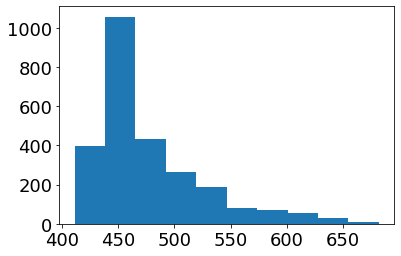

In [115]:
plt.hist(np.asarray(parages))

Text(0, 0.5, 'Bayesian')

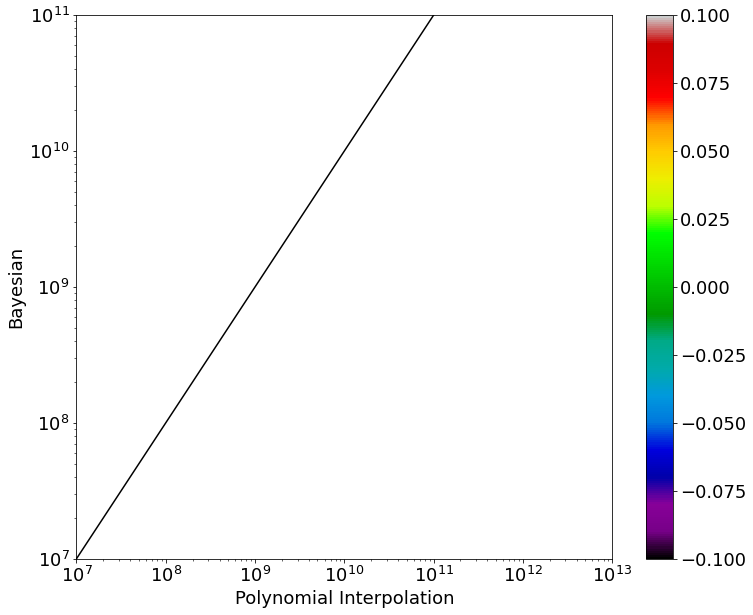

In [116]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(parages)[lmc_ind],10**pdfout['P_MEAN'][pdfout_ind],c=lmc['LOGG'][lmc_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Polynomial Interpolation')
plt.ylabel(r'Bayesian')

In [17]:
# plt.hist(10**pdfout['P_MEAN'][pdfout_ind])

In [18]:
# plt.hist(10**np.asarray(parages)[r13_ind])

In [19]:
# plt.hist(age_dist[100])

In [21]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

# cat.write('large_pca_ols_ages.fits',format='fits',overwrite=True)
# cat.write('TEST_pca_ols_ll.fits',format='fits',overwrite=True)

In [32]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Polynomial_LMC_Ages'

In [49]:
### Find all models

#transform data to new basis
# new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x0 = parsec['logTe'] #new_data[:,0]
x1 = parsec['Ksmag'] #new_data[:,1]
x2 = np.log10(parsec['Z']/0.02) #new_data[:,2]
x3 = parsec['logg']

# linear int
x01 = np.multiply(x0,x1) 
x02 = np.multiply(x0,x2)
x03 = np.multiply(x0,x3)
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x0sq = x0**2
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x0cu = x0**3
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x0','x1','x2','x3','x01','x02','x03','x12','x13','x23','x0sq','x1sq','x2sq','x3sq','x0cu','x1cu',
               'x2cu','x3xu']
all_var = [x0,x1,x2,x3,x01,x02,x03,x12,x13,x23,x0sq,x1sq,x2sq,x3sq,x0cu,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

# len(models)
# split_models = np.array_split(models,9)
# split_models_str = np.array_split(models_str,9)

import statsmodels.api as sm 

mads = []
maxs = []
all_params = []
ll = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
    maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
    all_params.append(np.asarray(model.params))
    ll.append(model.llf)

262143

In [24]:
### Fit All Models

# import statsmodels.api as sm 

# mads = []
# maxs = []
# all_params = []
# ll = []
# for i in tqdm_notebook(range(len(split_models[0])),desc='Done?'):
#     pmodl = np.array(split_models[0][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [25]:
# for i in tqdm_notebook(range(len(split_models[1])),desc='Done?'):
#     pmodl = np.array(split_models[1][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [26]:
# for i in tqdm_notebook(range(len(split_models[2])),desc='Done?'):
#     pmodl = np.array(split_models[2][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [27]:
# for i in tqdm_notebook(range(len(split_models[3])),desc='Done?'):
#     pmodl = np.array(split_models[3][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [28]:
# for i in tqdm_notebook(range(len(split_models[4])),desc='Done?'):
#     pmodl = np.array(split_models[4][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [29]:
# for i in tqdm_notebook(range(len(split_models[5])),desc='Done?'):
#     pmodl = np.array(split_models[5][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [31]:
# for i in tqdm_notebook(range(len(split_models[6])),desc='Done?'):
#     pmodl = np.array(split_models[6][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [32]:
# for i in tqdm_notebook(range(len(split_models[7])),desc='Done?'):
#     pmodl = np.array(split_models[7][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

In [33]:
# for i in tqdm_notebook(range(len(split_models[8])),desc='Done?'):
#     pmodl = np.array(split_models[8][i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     mads.append(afunc.mad(model.predict(pmodl)-parsec['logAge']))
#     maxs.append(np.max(model.predict(pmodl)-parsec['logAge']))
#     all_params.append(np.asarray(model.params))
#     ll.append(model.llf)

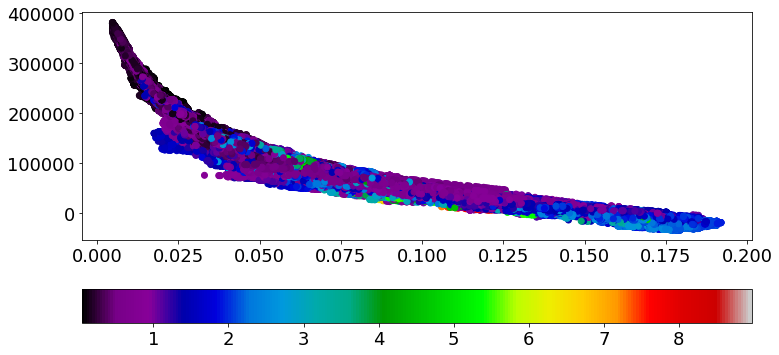

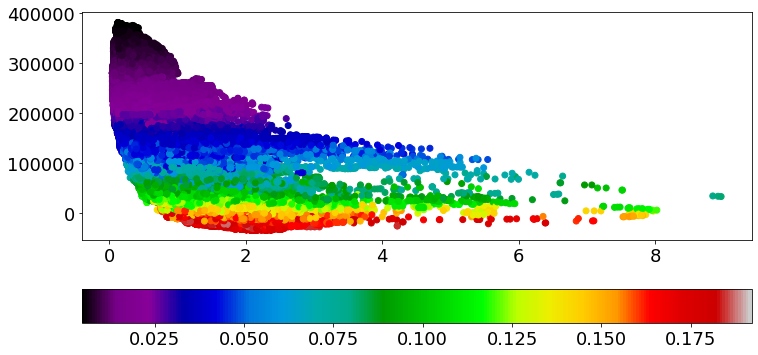

In [62]:
plt.scatter(mads,ll,c=maxs,cmap='nipy_spectral')
plt.colorbar(orientation='horizontal')
plt.show()
plt.scatter(maxs,ll,c=mads,cmap='nipy_spectral')
plt.colorbar(orientation='horizontal')
plt.show()

In [54]:
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])

['x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq'
 'x0cu' 'x1cu' 'x2cu' 'x3xu']
[ 8.64520784e+02 -6.90353991e+02  4.65667481e+00 -2.03726029e+00
 -6.78345280e+00 -4.81693744e-01  7.06378027e-01 -5.09451869e-01
 -3.79976473e-02  1.88652838e+02  1.07505826e-01  2.27720589e-01
  5.30896221e-01 -1.71228538e+01 -8.78325117e-04  3.58735574e-02
  9.94692780e-03]


In [55]:
print(models_str[np.asarray(maxs).argmin()])
print(all_params[np.asarray(maxs).argmin()])

['x1' 'x2' 'x3' 'x01' 'x13' 'x2sq' 'x2cu' 'x3xu']
[ 1.82597209e+01  3.23349699e+00  3.19800180e-01 -2.54867027e+00
 -5.82745926e-01  5.45486477e-02  1.65631468e-01  2.93817272e-02
 -1.62475788e-02]


In [58]:
print(models_str[np.asarray(ll).argmax()])
print(all_params[np.asarray(ll).argmax()])

['x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x03' 'x12' 'x13' 'x23' 'x0sq' 'x1sq'
 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 'x3xu']
[ 8.94843380e+02 -6.96537647e+02  1.88338806e+00 -5.59593977e+00
  1.57150421e+00  3.56546381e-01  1.80635222e+00 -2.56248536e+00
  4.05841381e-02 -6.01304213e-01 -1.74806505e-01  1.83251168e+02
  1.22127100e-01  2.78799920e-01  6.93699425e-01 -1.57704422e+01
 -6.38893329e-04  4.15472329e-02  8.57160604e-03]


In [63]:
def mads_age(z0,z1,z2,z3):
    #'x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 'x3xu'
    p = [8.64520784e+02,-6.90353991e+02,4.65667481e+00,-2.03726029e+00,-6.78345280e+00,-4.81693744e-01,
         7.06378027e-01,-5.09451869e-01,-3.79976473e-02,1.88652838e+02,1.07505826e-01,2.27720589e-01,
         5.30896221e-01,-1.71228538e+01,-8.78325117e-04,3.58735574e-02,9.94692780e-03]
    age = (p[0]+
           p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
           p[5]*(z0*z1)+p[6]*(z0*z2)+p[7]*(z1*z3)+p[8]*(z2*z3)+
           p[9]*(z0**2)+p[10]*(z1**2)+p[11]*(z2**2)+p[12]*(z3**2)+
           p[13]*(z0**3)+p[14]*(z1**3)+p[15]*(z2**3)+p[16]*(z3**3))
    return age

def maxs_age(z0,z1,z2,z3):
    #'x1' 'x2' 'x3' 'x01' 'x13' 'x2sq' 'x2cu' 'x3xu'
    p = [1.82597209e+01,3.23349699e+00,3.19800180e-01,-2.54867027e+00,-5.82745926e-01,5.45486477e-02,
         1.65631468e-01,2.93817272e-02,-1.62475788e-02]
    age = (p[0]+
           p[1]*z1+p[2]*z2+p[3]*z3+
           p[4]*(z0*z1)+p[5]*(z1*z3)+
           p[6]*(z2**2)+
           p[7]*(z2**3)+p[8]*(z3**3))
    return age

def ll_age(z0,z1,z2,z3):
    #'x0' 'x1' 'x2' 'x3' 'x01' 'x02' 'x03' 'x12' 'x13' 'x23' 'x0sq' 'x1sq' 'x2sq' 'x3sq' 'x0cu' 'x1cu' 'x2cu' 
    #'x3xu'
    p = [8.94843380e+02,-6.96537647e+02,1.88338806e+00,-5.59593977e+00,1.57150421e+00,3.56546381e-01,
         1.80635222e+00,-2.56248536e+00,4.05841381e-02,-6.01304213e-01,-1.74806505e-01,1.83251168e+02,
         1.22127100e-01,2.78799920e-01,6.93699425e-01,-1.57704422e+01,-6.38893329e-04,4.15472329e-02,
         8.57160604e-03]
    age = (p[0]+
           p[1]*z0+p[2]*z1+p[3]*z2+p[4]*z3+
           p[5]*(z0*z1)+p[6]*(z0*z2)+p[7]*(z0*z3)+p[8]*(z1*z2)+p[9]*(z1*z3)+p[10]*(z2*z3)+
           p[11]*(z0**2)+p[12]*(z1**2)+p[13]*(z2**2)+p[14]*(z3**2)+
           p[15]*(z0**3)+p[16]*(z1**3)+p[17]*(z2**3)+p[18]*(z3**3))
    return age

In [64]:
mads_age_dist = []
maxs_age_dist = []
ll_age_dist = []

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    am = r13['ALPHA_M'][i]
    am_err = r13['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    mads_age_noise = []
    maxs_age_noise = []
    ll_age_noise = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err)
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
#         x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
#         x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
#                                  add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = add_noise(am,am_err) #(x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
#         new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
        mads_age_noise.append(mads_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
        maxs_age_noise.append(maxs_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))
        ll_age_noise.append(ll_age(lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new))

#     for l in range(len(zs)):
#         noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    mads_age_dist.append(mads_age_noise)
    maxs_age_dist.append(maxs_age_noise)
    ll_age_dist.append(ll_age_noise)

mads_parages = [] 
maxs_parages = []
ll_parages = []

mads_devs = []
maxs_devs = []
ll_devs = []
for k in tqdm_notebook(range(len(mads_age_dist))):
    
    mads_devs.append(afunc.mad(mads_age_dist[k]))
    mads_parages.append(np.median(mads_age_dist[k]))
    
    maxs_devs.append(afunc.mad(maxs_age_dist[k]))
    maxs_parages.append(np.median(maxs_age_dist[k]))
    
    ll_devs.append(afunc.mad(ll_age_dist[k]))
    ll_parages.append(np.median(ll_age_dist[k]))

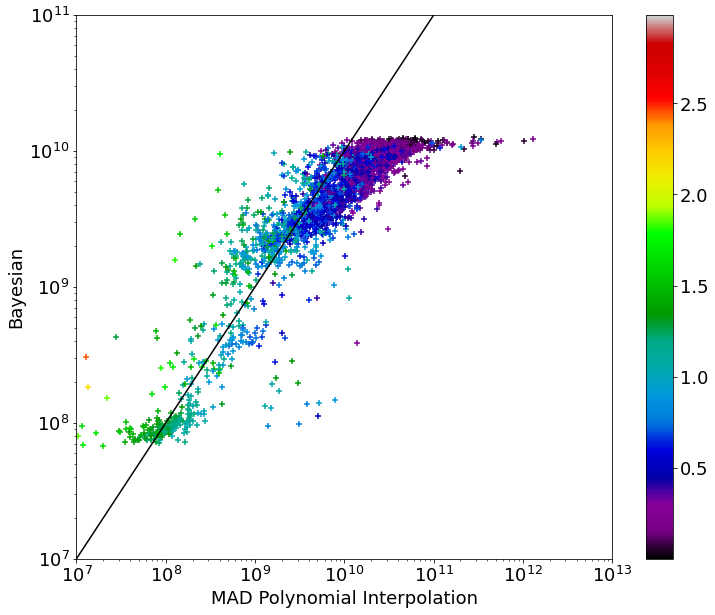

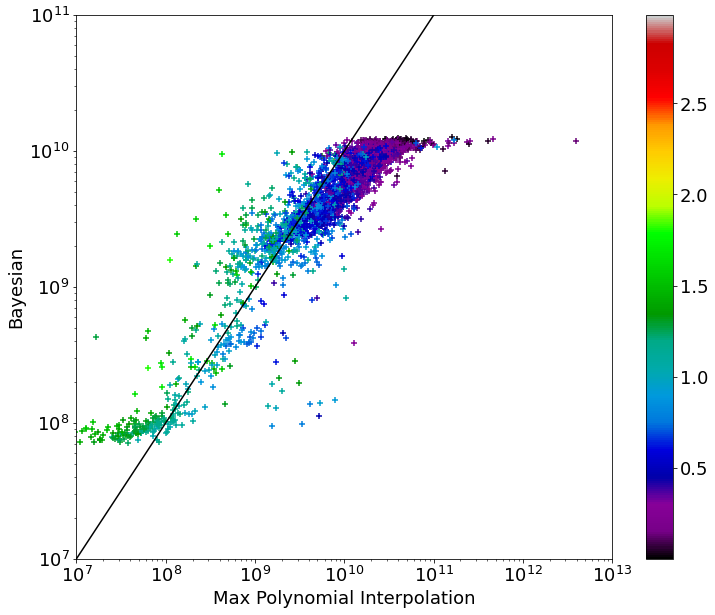

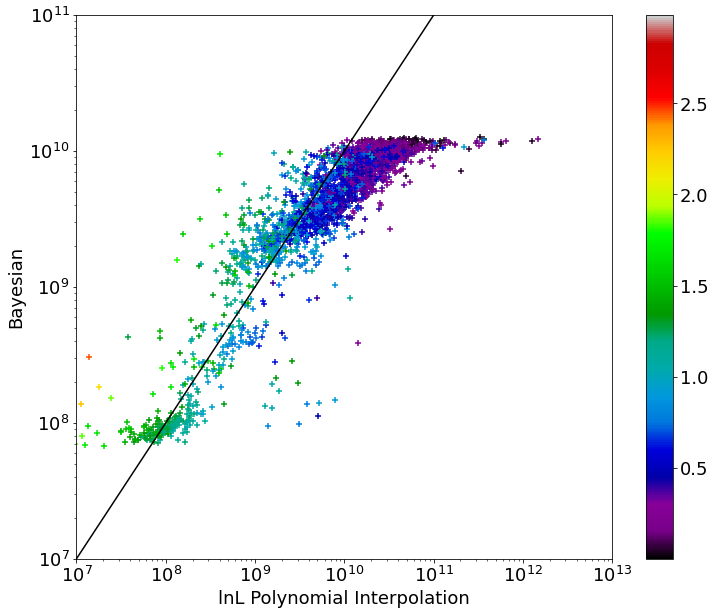

In [65]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mads_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'MAD Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

###############

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(maxs_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'Max Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

###############

plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages)[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
plt.ylim(10**7,10**11)
plt.xlim(10**7,10**13)

plt.xlabel(r'lnL Polynomial Interpolation')
plt.ylabel(r'Bayesian')
plt.show()

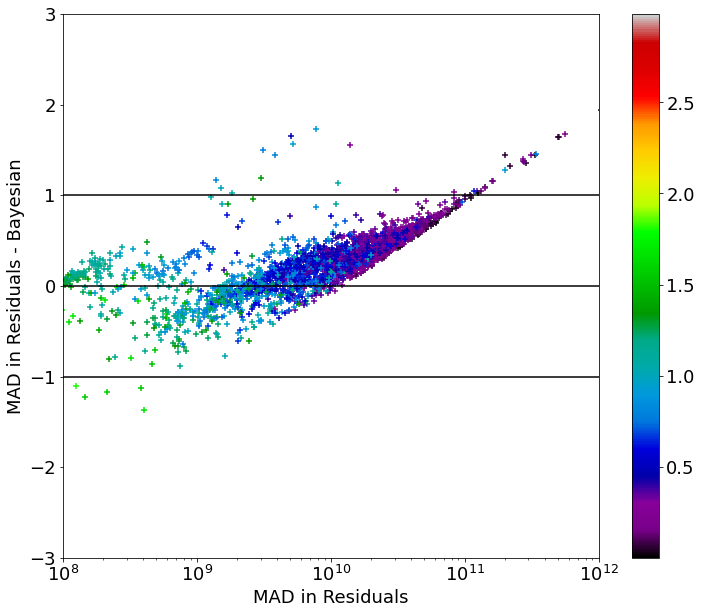

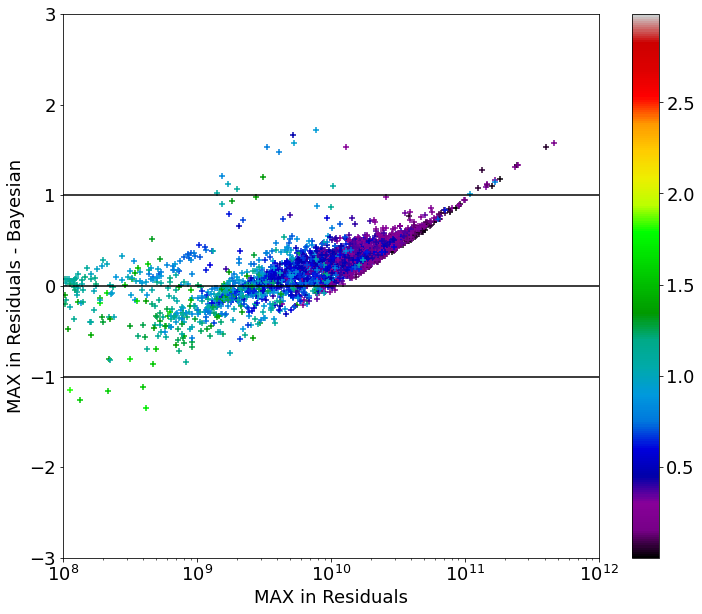

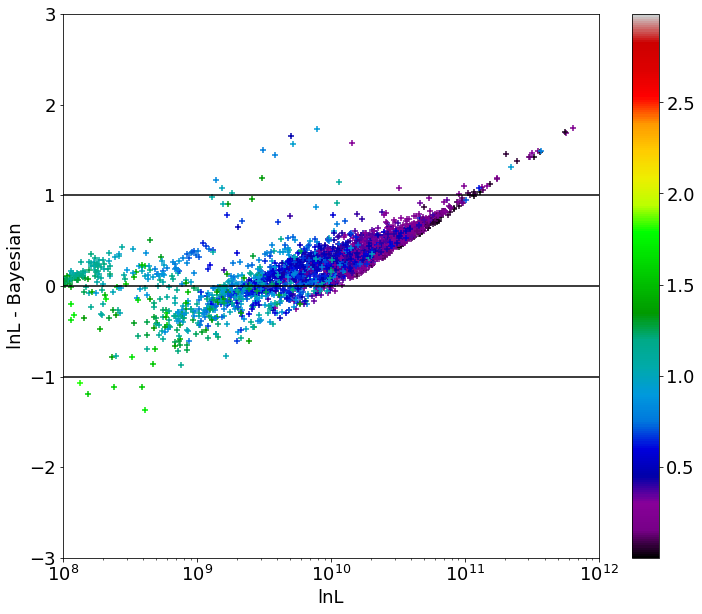

In [66]:
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(mads_parages)[r13_ind],
            (np.asarray(mads_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''MAD in Residuals - Bayesian''')
plt.xlabel(r'''MAD in Residuals''')
plt.show()

##########
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(maxs_parages)[r13_ind],
            (np.asarray(maxs_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''MAX in Residuals - Bayesian''')
plt.xlabel(r'''MAX in Residuals''')
plt.show()

##########
plt.figure(figsize=[12,10])
plt.scatter(10**np.asarray(ll_parages)[r13_ind],
            (np.asarray(ll_parages)[r13_ind]-pdfout['P_MEAN'][pdfout_ind]),
            c=r13['LOGG'][r13_ind],marker='+',cmap='nipy_spectral')
plt.axhline(0,c='k')
plt.axhline(-1,c='k')
plt.axhline(1,c='k')

plt.colorbar()
plt.xscale('log')
plt.ylim(-3,3)
plt.xlim(10**8,10**12)

plt.ylabel(r'''lnL - Bayesian''')
plt.xlabel(r'''lnL''')
plt.show()

In [67]:
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_mads_age = Column(np.asarray(mads_parages),name='MAD_AGE')
col_mads_dev = Column(np.asarray(mads_devs),name='MAD_AGE_ERR')
col_maxs_age = Column(np.asarray(maxs_parages),name='MAX_AGE')
col_maxs_dev = Column(np.asarray(maxs_devs),name='MAX_AGE_ERR')
col_ll_age = Column(np.asarray(ll_parages),name='ll_AGE')
col_ll_dev = Column(np.asarray(ll_devs),name='ll_AGE_ERR')

cat.add_column(col_id)
cat.add_column(col_mads_age)
cat.add_column(col_mads_dev)
cat.add_column(col_maxs_age)
cat.add_column(col_maxs_dev)
cat.add_column(col_ll_age)
cat.add_column(col_ll_dev)

cat.write('largeparsec_ages.fits',format='fits')#,overwrite=True)